In [1]:
import os, arrow
from elasticsearch import Elasticsearch
from datetime import datetime
from config import SOC_ES_HOST,SOC_ES_USER, SOC_ES_PASSWORD, SOC_ES_PORT

import requests
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
import nltk
import pandas as pd

from datetime import timezone

In [2]:
from elasticsearch import Elasticsearch

es = Elasticsearch([SOC_ES_HOST], http_auth=(SOC_ES_USER, SOC_ES_PASSWORD), port=SOC_ES_PORT, timeout=60)

if es.ping():
    print("Elasticsearch is connected.")
else:
    print("Elasticsearch is not connected.")


Elasticsearch is connected.


In [3]:
from datetime import datetime

def date_function(day, month, year):
    date_obj = datetime(year, month, day)
    date_str = date_obj.isoformat(timespec='milliseconds')
    return date_str

print(date_function(15, 1, 2020)) # Output = 2020-01-15T00:00:00.000


2020-01-15T00:00:00.000


In [4]:
from datetime import datetime, timedelta


def date_function(month, day, year):
    date_object = datetime(year, month, day, tzinfo=timezone.utc)
    return date_object.strftime('%d/%m/%Y')

def set_el_string(query: str) -> str:
    return "%s" % query.replace('|', 'OR') \
        .replace('/', '') \
        .replace('&', ' AND ')

doc = {
    "size": 1,
    "query": {
        "bool": {
            "must": [
                {
                    "match": {
                        "full_text": "covid"
                    }
                }
            ],
            "filter": [
                {
                    "term": {
                        "lang": "en"
                    }
                },
                {
                    "range": {
                        "created_at": {
                            "gte": "01/03/2020",
                            "lte": "01/04/2020",
                            "format": "dd/MM/yyyy"
                        }
                    }
                }
            ]
        }
    }
}




def get_news(index, keyword=None, query=None, start=None, end=None, doc=None, size=10):
    if doc is None:
        doc = {
            "size": size,
            "query": {
                "bool": {
                    "must": [
                        {
                            "query_string": {
                                "query": "*"
                            }
                        }
                    ],
                    "filter": [
                        {
                            "range": {
                                "created_at": {
                                    "gte": "",
                                    "lte": "",
                                    "format": "dd/MM/yyyy"
                                }
                            }
                        }
                    ]
                }
            }
        }

        if keyword is not None:
            query = set_el_string(keyword['keywords']) + " AND " + query

        doc["query"]["bool"]["must"][0]["query_string"]["query"] = query

        if start is not None and end is not None:
            doc["query"]["bool"]["filter"][0]["range"]["created_at"]["gte"] = start
            doc["query"]["bool"]["filter"][0]["range"]["created_at"]["lte"] = end

    if es.indices.exists(index=index):
        res = es.search(index=index, body=doc, scroll="1m")
        print("Elasticsearch response:", res)

        data = []
        scroll_id = res["_scroll_id"]

        while len(res["hits"]["hits"]):
            for hit in res["hits"]["hits"]:
                data.append(hit)

            res = es.scroll(scroll_id=scroll_id, scroll="1m")
            scroll_id = res["_scroll_id"]

        return data
    else:
        print("Index not found")
        return []

# function to add weeks to a date
def add_weeks(date, weeks):
    return date + timedelta(weeks=weeks)



In [14]:
""" doc = {
    "size": 1, 
    "query": {
        "bool": {
            "must": [
                {
                    "match": {
                        "full_text": "covid"
                    }
                }
            ],
            "filter": [
                {
                    "term": {
                        "lang": "en"
                    }
                },
                {
                    "range": {
                        "created_at": {
                            "gte": "20/01/2020", 
                            "lte": "26/01/2020",
                            "format": "dd/MM/yyyy"
                        }
                    }
                }
            ]
        }
    }
}


start_date = datetime(2020, 1, 20, tzinfo=timezone.utc)

# Iterate over weeks
for week in range(25):
    current_start_date = add_weeks(start_date, week)
    current_end_date = add_weeks(current_start_date, 1)
    
    # query with the date range
    doc["query"]["bool"]["filter"][1]["range"]["created_at"]["gte"] = current_start_date.strftime('%d/%m/%Y')
    doc["query"]["bool"]["filter"][1]["range"]["created_at"]["lte"] = current_end_date.strftime('%d/%m/%Y')
    
    index = 'covidtweets'
    data = get_news(index=index, doc=doc, start=current_start_date.strftime('%d/%m/%Y'), end=current_end_date.strftime('%d/%m/%Y'))
    

    dataset = []
    for item in data:
        dataset.append(item['_source'])

    df = pd.DataFrame.from_dict(dataset)
    

    output_filename = f'data_week_{current_start_date.strftime("%Y_%m_%d")}_to_{current_end_date.strftime("%Y_%m_%d")}.txt'
    df.to_csv(output_filename, sep='\t', index=False)

    print(f'Saved data for week {week + 1} to file: {output_filename}') """

' doc = {\n    "size": 1, \n    "query": {\n        "bool": {\n            "must": [\n                {\n                    "match": {\n                        "full_text": "covid"\n                    }\n                }\n            ],\n            "filter": [\n                {\n                    "term": {\n                        "lang": "en"\n                    }\n                },\n                {\n                    "range": {\n                        "created_at": {\n                            "gte": "20/01/2020", \n                            "lte": "26/01/2020",\n                            "format": "dd/MM/yyyy"\n                        }\n                    }\n                }\n            ]\n        }\n    }\n}\n\n\n# Data starts from 20 jan 2020\nstart_date = datetime(2020, 1, 20, tzinfo=timezone.utc)\n\n# Iterate 25 weeks\nfor week in range(25):\n    # the start and end dates for the corresponding week\n    current_start_date = add_weeks(start_date, week)\n  

In [5]:
df_dict = {}

for week in range(1, 16):

    start_date = (datetime(2020, 2, 10, tzinfo=timezone.utc) + timedelta(weeks=week-1)).strftime('%Y_%m_%d')
    end_date = (datetime(2020, 2, 10, tzinfo=timezone.utc) + timedelta(weeks=week)).strftime('%Y_%m_%d')
    filename = f'weeks_eng/data_week_{start_date}_to_{end_date}.txt'
    
    df = pd.read_csv(filename, sep='\t')
    
    df_dict[f'df{week}'] = df


/tmp/ipykernel_147335/2158517795.py:9: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, sep='\t')
/tmp/ipykernel_147335/2158517795.py:9: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, sep='\t')
/tmp/ipykernel_147335/2158517795.py:9: DtypeWarning: Columns (11,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, sep='\t')


In [6]:
stats = {}

for key, df in df_dict.items():
    num_rows = df.shape[0]
    stats[key] = num_rows

# Print the statistics
for key, num_rows in stats.items():
    print(f'{key}: {num_rows} rows')


df1: 3014 rows
df2: 2560 rows
df3: 11348 rows
df4: 16137 rows
df5: 7029 rows
df6: 15788 rows
df7: 17013 rows
df8: 32398 rows
df9: 25723 rows
df10: 30128 rows
df11: 38905 rows
df12: 28624 rows
df13: 28625 rows
df14: 28375 rows
df15: 37407 rows


In [8]:
stats_df = pd.DataFrame(list(stats.items()), columns=['DataFrame', 'NumRows'])

print(stats_df)


   DataFrame  NumRows
0        df1     3014
1        df2     2560
2        df3    11348
3        df4    16137
4        df5     7029
5        df6    15788
6        df7    17013
7        df8    32398
8        df9    25723
9       df10    30128
10      df11    38905
11      df12    28624
12      df13    28625
13      df14    28375
14      df15    37407


In [9]:
from spacy.lang.fr.stop_words import STOP_WORDS as en_stop

# Tokenize and remove unwanted words.

def preprocess_text(text):
    nltk.download('punkt')
    nltk.download('stopwords')
    tokens = word_tokenize(text.lower())
    english_stopwords = set(stopwords.words('english'))

    missed_stopwords = ['rt', 'https', 'name']

    stopwords_from_spacy = list(en_stop)
    english_stopwords.update(missed_stopwords)
    english_stopwords.update(stopwords_from_spacy)
    
    unwanted_tokens = english_stopwords.union({"'", "’", "-", "»", "«"})
    filtered_tokens = [token for token in tokens if token not in unwanted_tokens and token.isalpha()]
    return filtered_tokens

def count_words(tokens):
    return Counter(tokens)


# to remove html tags
def extract_text(articles):
    ''' input: List of article
        returns:
            whole text without html tags
    '''
    text = ""
    for article in articles:
        soup = BeautifulSoup(article, 'html.parser')
        text += soup.get_text()
    return text

def extract_text_from_single_article(article):
    '''
    input : 
            Single article
    returns :  
            Text version of article without html tags
    '''
    soup = BeautifulSoup(article, 'html.parser')
    return soup.get_text()




In [60]:
# Data of first week

df1 = df_dict['df1']

In [61]:
df1.columns

Index(['lang', 'full_text', 'created_at', 'coordinates',
       'in_reply_to_user_id_str', 'in_reply_to_status_id_str', 'place',
       'id_str', 'retweet_count', 'geo', 'id', 'favorite_count', 'user',
       'entities'],
      dtype='object')

In [65]:
df1 = df1.dropna(subset=['full_text'])
df1['cleaned_text'] = df1['full_text'].apply(extract_text_from_single_article)
df1['preprocessed_text'] = df1['cleaned_text'].apply(preprocess_text)

/home/zeki/.local/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
[nltk_data] Downloading package punkt to /home/zeki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zeki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/zeki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zeki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/zeki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zeki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt t

In [72]:
df1['counted_words'] = df1['preprocessed_text'].apply(Counter)

In [83]:
counter_all = df1['counted_words'].sum()
counter_all = sorted(counter_all.items(), key=lambda x: x[1], reverse=True)

In [12]:
import pandas as pd
from collections import defaultdict

def create_table(df):

    all_words = [word for words in df['preprocessed_text'] for word in words]

    word_freq = pd.Series(all_words).value_counts().reset_index()
    word_freq.columns = ['word', 'frequency']

    article_word_freq = df['preprocessed_text'].apply(lambda x: pd.Series(x).value_counts().to_dict()).to_list()
    word_freq['article_frequency'] = [defaultdict(int) for _ in range(len(word_freq))]
    
    for i, word in enumerate(word_freq['word']):
        for j, article_dict in enumerate(article_word_freq):
            if word in article_dict:
                word_freq.at[i, 'article_frequency'][j] = article_dict[word]

    word_freq.sort_values(by='frequency', ascending=False, inplace=True)
    
    return word_freq

#df_table = create_table(df1)


In [86]:
df_table

word  frequency  \
0     coronavirus       1585   
1             new        587   
2           china        556   
3         disease        444   
4           virus        401   
...           ...        ...   
3278        fault          1   
3279        bonds          1   
3280      careful          1   
3281          wtf          1   
5071   intimately          1   

                                      article_frequency  
0     {1: 1, 10: 1, 11: 1, 12: 1, 14: 1, 15: 1, 16: ...  
1     {30: 1, 38: 1, 41: 1, 61: 1, 63: 1, 64: 2, 98:...  
2     {19: 1, 37: 1, 42: 1, 62: 1, 73: 1, 76: 1, 90:...  
3     {12: 1, 13: 1, 20: 1, 21: 1, 23: 1, 24: 1, 26:...  
4     {13: 1, 20: 1, 21: 1, 22: 1, 23: 1, 25: 1, 42:...  
...                                                 ...  
3278                                          {2982: 1}  
3279                                          {2980: 1}  
3280                                          {2976: 1}  
3281                                          {2977: 1}  
5071                                          {3013: 1}  

[5072 rows x 3 columns]

In [121]:
import numpy as np

word1_info=df_table['article_frequency'].iloc[1]
word2_info=df_table['article_frequency'].iloc[34]

inter_keys = set(word1_info).intersection(word2_info)
union_keys = set(word1_info).union(word2_info)

vec1 = [word1_info[key] for key in inter_keys]
vec2 = [word2_info[key] for key in inter_keys]

connection1 = np.dot(vec1,vec2)/df1.shape[0]

connection2 = np.dot(vec1,vec2)/(len(union_keys))

connection3 = np.dot(vec1,vec2)/len(inter_keys)

In [16]:
def get_connection(df,word_1,word_2):
    """ 
    Function to find the strenght of the connection between two words
        input: index of 2 words
        returns: three types of connections
    """

    df_table = create_table(df)
    word1_info=df_table['article_frequency'].iloc[word_1]
    word2_info=df_table['article_frequency'].iloc[word_2]

    inter_keys = set(word1_info).intersection(word2_info)
    union_keys = set(word1_info).union(word2_info)

    vec1 = [word1_info[key] for key in inter_keys]
    vec2 = [word2_info[key] for key in inter_keys]

    connection1 = np.dot(vec1,vec2)/df.shape[0]

    connection2 = np.dot(vec1,vec2)/(len(union_keys))

    connection3 = np.dot(vec1,vec2)/len(inter_keys)

    return connection1, connection2, connection3

/tmp/ipykernel_107627/273037244.py:21: RuntimeWarning: invalid value encountered in true_divide
  connection3 = np.dot(vec1,vec2)/len(inter_keys)


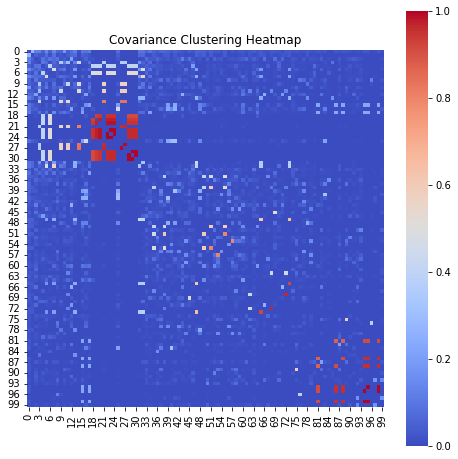

In [157]:
import numpy as np
from itertools import combinations

M = 100 

df1_table_M = df_table[:M]

word_indexes= df1_table_M.index # to get i th popular word, select i+1 as index.

combinations_indexes = list(combinations(word_indexes, 2))

indices = list(range(100))

connection_matrix = np.zeros((100, 100))
for i, j in combinations(indices, 2):
    connection = get_connection(i, j)[1] # put 0,1 or 2 to see different distances impact on the result.
    connection_matrix[i, j] = connection
    connection_matrix[j, i] = connection 

plt.figure(figsize=(8, 8))
sns.heatmap(connection_matrix, cmap='coolwarm', square=True, annot=False, cbar=True)
plt.title('Covariance Clustering Heatmap')
plt.show()

/tmp/ipykernel_107627/273037244.py:21: RuntimeWarning: invalid value encountered in true_divide
  connection3 = np.dot(vec1,vec2)/len(inter_keys)


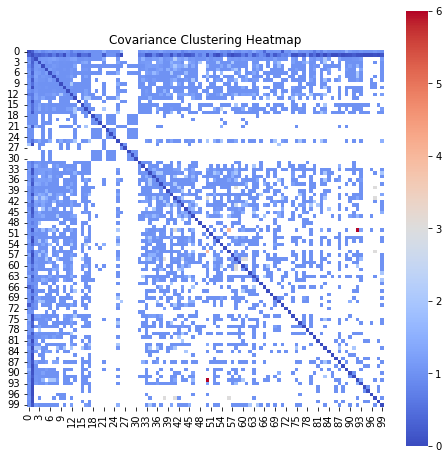

In [158]:
import numpy as np
from itertools import combinations

M = 100 

df1_table_M = df_table[:M]

word_indexes= df1_table_M.index # to get i th popular word, select i+1 as index.

combinations_indexes = list(combinations(word_indexes, 2))

indices = list(range(100))

connection_matrix = np.zeros((100, 100))
for i, j in combinations(indices, 2):
    connection = get_connection(i, j)[2] # put 0,1 or 2 to see different distances impact on the result.
    connection_matrix[i, j] = connection
    connection_matrix[j, i] = connection 


plt.figure(figsize=(8, 8))
sns.heatmap(connection_matrix, cmap='coolwarm', square=True, annot=False, cbar=True)
plt.title('Covariance Clustering Heatmap')
plt.show()

In [51]:
import pandas as pd
from collections import Counter

# Set M as the number of top frequent words to consider
M = 100

# Get the top M most frequent words
all_words = []
for tokens in df1['preprocessed_text']:
    all_words.extend(tokens)
word_frequencies = Counter(all_words)
top_100_words_with_freq = [(word,freq) for word, freq in word_frequencies.most_common(M)]
top_100_words = [word for word,_ in word_frequencies.most_common(M)]



In [14]:
from itertools import combinations

# Function to create word pairs from an article's preprocessed text
def create_word_pairs(top_M_words):
    words = set(top_M_words)
    return set(combinations(words, 2))

# It will used if necessary, because it requires a lot of computation

In [53]:
# Create a co-occurrence matrix for the specific words
cooccurrence_matrix = pd.DataFrame(0, index=top_100_words, columns=top_100_words)

# co-occurrence matrix
for tokens in df1['preprocessed_text']:
    for word_1 in set(tokens):
        if word_1 in top_100_words:
            for word_2 in set(tokens):
                if word_2 in top_100_words:
                    cooccurrence_matrix.loc[word_1, word_2] += 1
                    if word_1 != word_2:
                        cooccurrence_matrix.loc[word_2, word_1] += 1

print(cooccurrence_matrix)

              coronavirus  new  china  disease  virus  health  wuhan  world  \
coronavirus          1479  844    348      376    152     432    114    408   
new                   844  572    166      108     84     254     44    280   
china                 348  166    520       32    128      64    110     80   
disease               376  108     32      431    128      96     12     88   
virus                 152   84    128      128    387      50    376     52   
...                   ...  ...    ...      ...    ...     ...    ...    ...   
light                   2    0      0        0      0       0      0      0   
purposefully           82    0      0        0      0       0      0      0   
avoids                 82    0      0        0      0       0      0      0   
references             82    0      0        0      0       0      0      0   
reported               36   14     30        8      8       6      2      0   

              outbreak  breaking  ...  positive  kn

In [54]:
def get_occurence(word_1,word_2,cooccurrence_matrix):
    occ = cooccurrence_matrix.loc[word_1,word_2]
    return occ

# Create the covariance matrix
n = len(top_100_words)
covariance_matrix = np.zeros((n, n))
A=(df.shape[0])

for i, (word_1, frequency_1) in enumerate(top_100_words_with_freq):
    for j, (word_2, frequency_2) in enumerate(top_100_words_with_freq):
        covariance = np.abs(get_occurence(word_1, word_2, cooccurrence_matrix) / A - frequency_1 * frequency_2 / (A ** 2))
        covariance_matrix[i, j] = covariance



In [55]:
print("Covariance matrix of top 100 words:")
print(covariance_matrix)

Covariance matrix of top 100 words:
[[3.77426893e-02 2.18977139e-02 8.67327794e-03 ... 2.14566146e-03
  2.14566146e-03 9.17077821e-04]
 [2.18977139e-02 1.50450089e-02 4.20442989e-03 ... 1.71995149e-05
  1.71995149e-05 3.57481487e-04]
 [8.67327794e-03 4.20442989e-03 1.36802170e-02 ... 1.62911930e-05
  1.62911930e-05 7.86095086e-04]
 ...
 [2.14566146e-03 1.71995149e-05 1.62911930e-05 ... 1.09485021e-03
  2.19090175e-03 1.17202827e-06]
 [2.14566146e-03 1.71995149e-05 1.62911930e-05 ... 2.19090175e-03
  1.09485021e-03 1.17202827e-06]
 [9.17077821e-04 3.57481487e-04 7.86095086e-04 ... 1.17202827e-06
  1.17202827e-06 9.61243277e-04]]


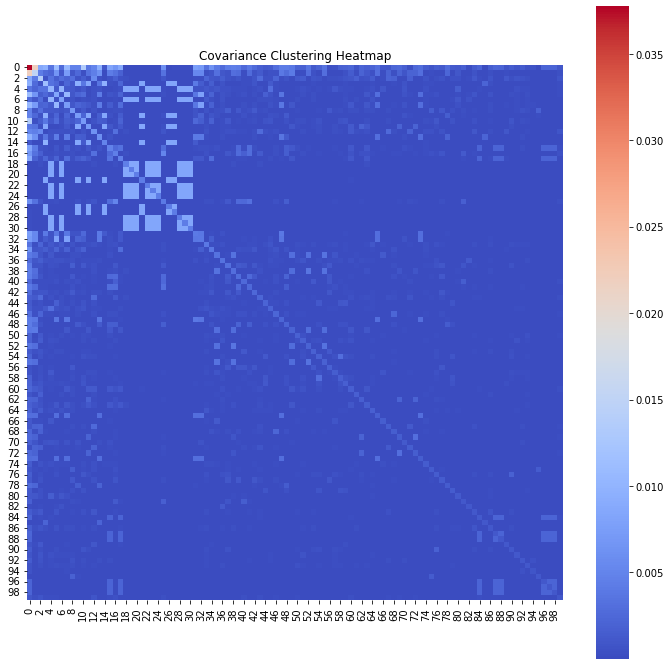

In [56]:
plt.figure(figsize=(12, 12))
sns.heatmap(covariance_matrix, cmap='coolwarm', square=True, annot=False, cbar=True)
plt.title('Covariance Clustering Heatmap')
plt.show()

In [57]:
import numpy as np
cov_matrix = covariance_matrix

# Compute the standard deviations of the variables
std_devs = np.sqrt(np.diag(cov_matrix))

# Normalize the covariance matrix to obtain the correlation matrix
correlation_matrix = cov_matrix / np.outer(std_devs, std_devs)

print(correlation_matrix)

[[1.00000000e+00 9.18937831e-01 3.81698408e-01 ... 3.33785469e-01
  3.33785469e-01 1.52255543e-01]
 [9.18937831e-01 1.00000000e+00 2.93065298e-01 ... 4.23782111e-03
  4.23782111e-03 9.40027748e-02]
 [3.81698408e-01 2.93065298e-01 1.00000000e+00 ... 4.20948573e-03
  4.20948573e-03 2.16776365e-01]
 ...
 [3.33785469e-01 4.23782111e-03 4.20948573e-03 ... 1.00000000e+00
  2.00109725e+00 1.14246809e-03]
 [3.33785469e-01 4.23782111e-03 4.20948573e-03 ... 2.00109725e+00
  1.00000000e+00 1.14246809e-03]
 [1.52255543e-01 9.40027748e-02 2.16776365e-01 ... 1.14246809e-03
  1.14246809e-03 1.00000000e+00]]


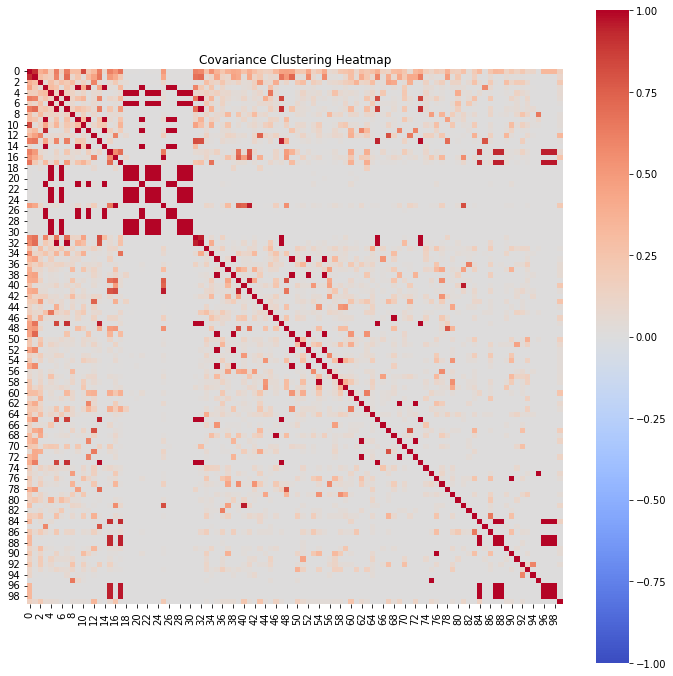

In [58]:
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm',vmin=-1, vmax=1, square=True, annot=False, cbar=True)
plt.title('Covariance Clustering Heatmap')
plt.show()

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

M = 100 

for key in df_dict.keys():
    df = df_dict[key]
    df = df.dropna(subset=['full_text'])
    df['cleaned_text'] = df['full_text'].apply(extract_text_from_single_article)
    df['preprocessed_text'] = df['cleaned_text'].apply(preprocess_text)
    df['counted_words'] = df['preprocessed_text'].apply(Counter)
    df_table = create_table(df)

    df_table_M = df_table[:M]

    word_indexes = df_table_M.index 
    combinations_indexes = list(combinations(word_indexes, 2))

    indices = list(range(100))

    connection_matrix = np.zeros((100, 100))
    for i, j in combinations(indices, 2):
        connection = get_connection(df,i, j)[1]
        connection_matrix[i, j] = connection
        connection_matrix[j, i] = connection 

    plt.figure(figsize=(8, 8))
    sns.heatmap(connection_matrix, cmap='coolwarm', square=True, annot=False, cbar=True)
    plt.title('Covariance Clustering Heatmap for ' + key)
    plt.show()


/home/zeki/.local/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
[nltk_data] Downloading package punkt to /home/zeki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zeki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/zeki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zeki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/zeki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zeki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt t